# Plotting

This notebook is running Julia 0.4 so I can actually plot things.

## Getting data

In [2]:
using DataStructures
using DataFrames
using DataFramesMeta
using Gadfly
using Compose
using JSON
set_default_plot_size(22cm, 15cm)

In [43]:
base_counts = deserialize(open("data/base_counts.jld"))
eco_counts = deserialize(open("data/eco_counts.jld"))

DataStructures.DefaultDict{Symbol,Int64,Int64} with 86 entries:
  :if                 => 53780
  :$=                 => 80
  :.'                 => 167
  :\=                 => 2
  :&=                 => 78
  :export             => 24571
  :type               => 8961
  :tuple              => 110757
  :./=                => 61
  :string             => 11924
  :dict_comprehension => 130
  :(=)                => 383353
  :for                => 27339
  :kw                 => 49616
  :cell1d             => 557
  :(:=)               => 11
  :try                => 1954
  :macrocall          => 133020
  :<<=                => 37
  :...                => 14824
  :ref                => 154337
  :using              => 10809
  :.^=                => 2
  :'                  => 3384
  :return             => 28748
  ⋮                   => ⋮

In [44]:
function to_df(d::Associative)
    df = DataFrame()
    ks = []
    vs = []
    for (k,v) in d
        push!(ks, k)
        push!(vs, v)
    end
    df[:h] = map(string, ks)
    df[:head] = map(x->Markdown.htmlesc(string(x)), ks)
    df[:count] = vs
    df
end

to_df (generic function with 1 method)

In [45]:
bdf = to_df(base_counts)
edf = to_df(eco_counts)
rename!(bdf, :count, :b_count)
rename!(edf, :count, :e_count)
df = join(edf, bdf, on=[:head, :h], kind=:left)
df[df[:b_count].na, :b_count] = 0 # Set NA values to 0s

0

In [46]:
function make_df()
    bdf = to_df(base_counts)
    edf = to_df(eco_counts)
    rename!(bdf, :count, :b_count)
    rename!(edf, :count, :e_count)
    df = join(edf, bdf, on=[:head, :h], kind=:left)
    df[df[:b_count].na, :b_count] = 0 # Set NA values to 0s
    df
end

make_df (generic function with 1 method)

In [47]:
setdiff(keys(eco_counts), keys(base_counts))

11-element Array{Symbol,1}:
 :\=            
 :cell1d        
 :(:=)          
 :.^=           
 :-->           
 :.-=           
 :stagedfunction
 :incomplete    
 :cell2d        
 :typed_dict    
 :dict          

In [48]:
df[:b_count].na

86-element BitArray{1}:
 false
 false
 false
 false
 false
 false
 false
 false
 false
 false
 false
 false
 false
     ⋮
 false
 false
 false
 false
 false
 false
 false
 false
 false
 false
 false
 false

## Plot of expression counts

* I want to see a relative count of each 

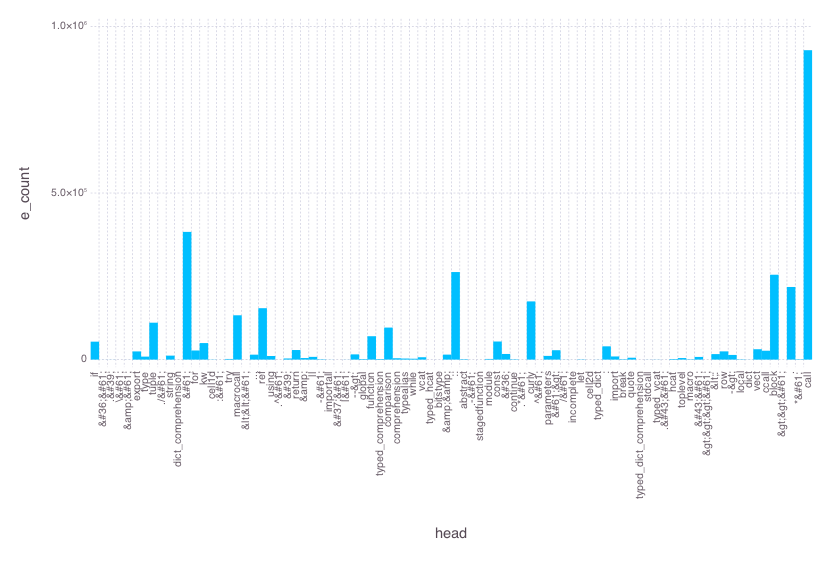

In [49]:
plot(edf, x="head", y="e_count", Geom.bar(position=:dodge))

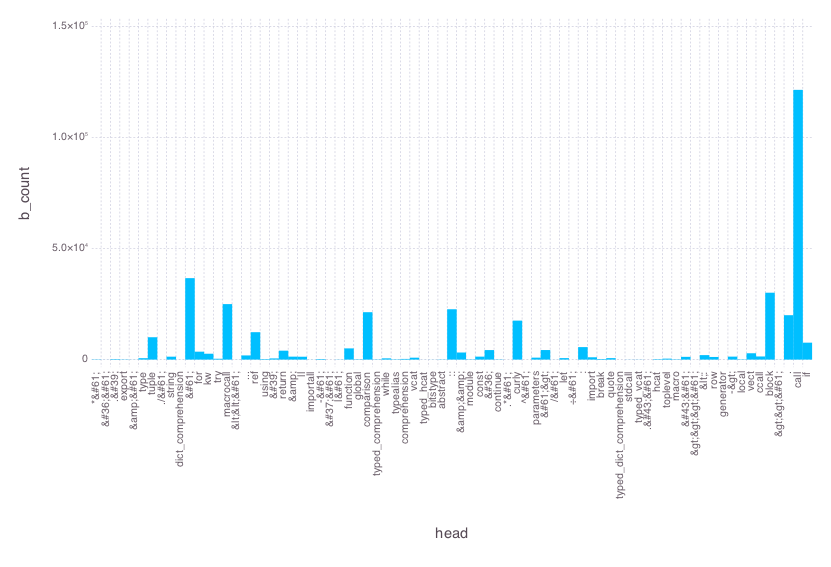

In [50]:
plot(bdf, x="head", y="b_count", Geom.bar(position=:dodge))

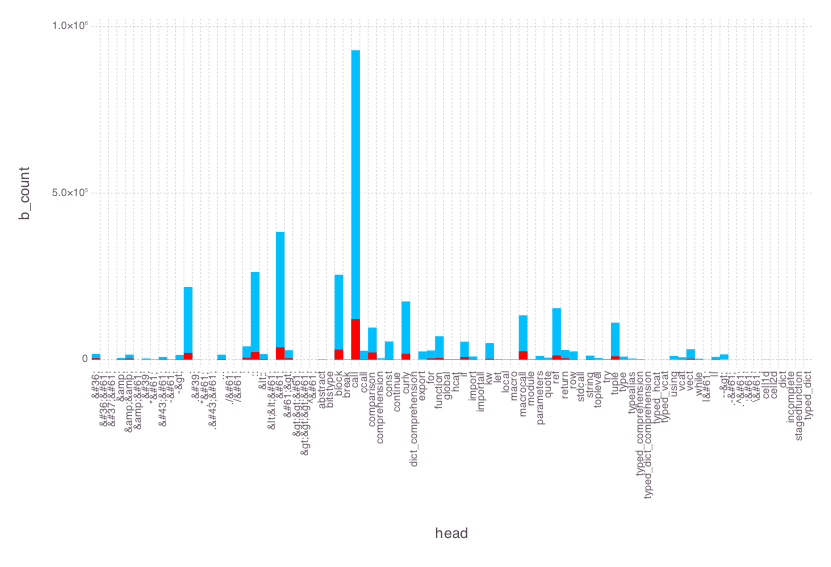

In [51]:
plot(df, 
layer(x="head", y="b_count", Theme(default_color=color("red")), Geom.bar(position=:dodge)),
layer(x="head", y="e_count", Geom.bar(position=:dodge)))

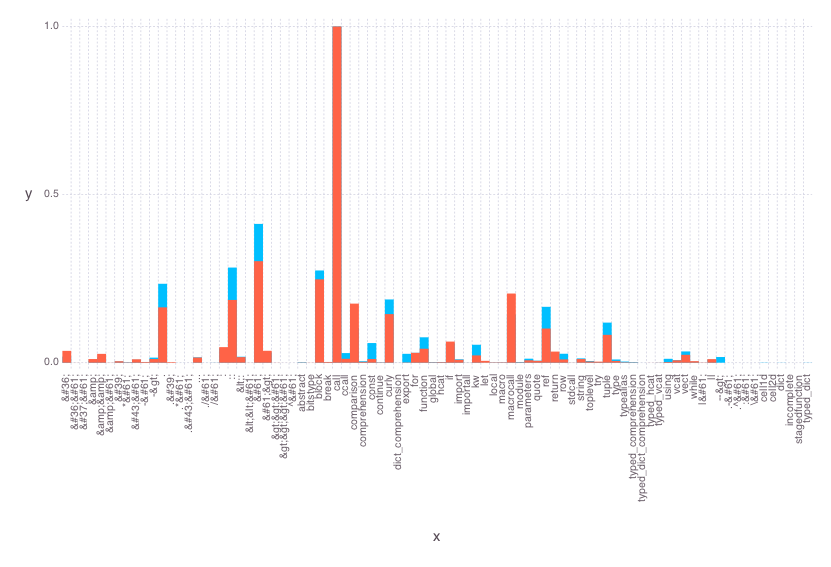

In [52]:
plot(#df, 
layer(x=df[:head], 
      y=df[:b_count]./maximum(df[:b_count]), 
      Theme(default_color=color("tomato"), panel_opacity=0.5), 
      Geom.bar(position=:stack)
),
layer(x=df[:head], 
      y=df[:e_count]./maximum(df[:e_count]), 
      Geom.bar(position=:stack)
))

In [53]:
df2 = stack(df, [:b_count, :e_count])

,variable,value,h,head
1,b_count,4289,$,&#36;
2,b_count,25,$=,&#36;&#61;
3,b_count,4,%=,&#37;&#61;
4,b_count,1330,&,&amp;
5,b_count,3194,&&,&amp;&amp;
6,b_count,41,&=,&amp;&#61;
7,b_count,532,',&#39;
8,b_count,132,*=,*&#61;
9,b_count,1241,+=,&#43;&#61;
10,b_count,266,-=,-&#61;


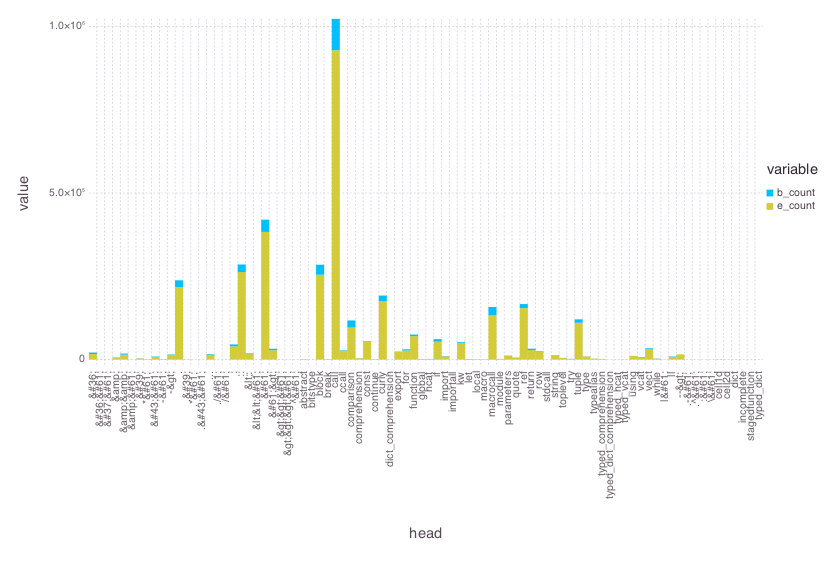

In [54]:
plot(df2,
x="head",
y="value",
color="variable",
Geom.bar())

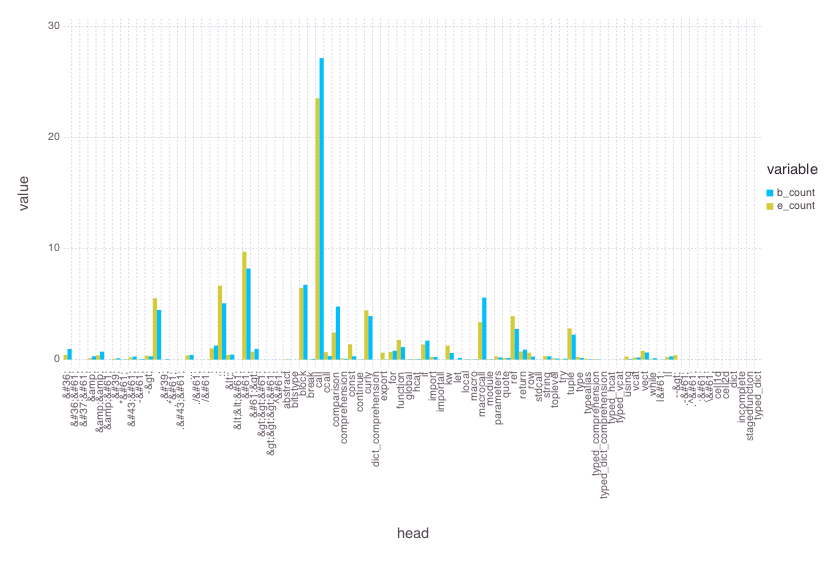

In [55]:
begin
    df3 = copy(df)
    df3[:b_count] = df3[:b_count]./mean(df3[:b_count]) #
    df3[:e_count] = df3[:e_count]./mean(df3[:e_count])
    df3_stacked = stack(df3, [:b_count, :e_count])
    
    plot(df3_stacked,
        x="head",
        y="value",
        color="variable",
        Geom.bar(position=:dodge)
    )
#     plot(df3,
#     x=df3[:head]
    #     y=df3[:])
end


In [56]:
df2

,variable,value,h,head
1,b_count,4289,$,&#36;
2,b_count,25,$=,&#36;&#61;
3,b_count,4,%=,&#37;&#61;
4,b_count,1330,&,&amp;
5,b_count,3194,&&,&amp;&amp;
6,b_count,41,&=,&amp;&#61;
7,b_count,532,',&#39;
8,b_count,132,*=,*&#61;
9,b_count,1241,+=,&#43;&#61;
10,b_count,266,-=,-&#61;


## Trying to do some normalization

In [62]:
df = make_df() ;

In [58]:
df = make_count_df() ;

In [63]:
# Transformation

df[:e_norm] = df[:e_count] / sum(df[:e_count])
df[:b_norm] = df[:b_count] / sum(df[:b_count])
df[:total] = df[:e_count] + df[:b_count]
sort!(df, cols=:total)

@byrow! df begin
    e = :e_norm
    b = :b_norm
    :e_norm = e/(e+b)
    :b_norm = b/(e+b)
end

df_stacked = stack(df, [:b_norm, :e_norm], [:head,:total]);

In [ ]:
plot(df_stacked,
        x="head",
        y="value",
        color="variable",
    Geom.bar(position=:stack)
    )

In [64]:
a = plot(df_stacked,
        x="head",
        y="value",
        color="variable",
    Geom.bar(position=:stack),
Theme(guide_title_position=:left,
#         bar_spacing=2px,
key_position=:top,
bar_highlight=color("white")
),
Guide.title("Relative expression usage"),
Guide.xlabel(nothing),
Guide.annotation(compose(context(), rectangle(0, .4995, 100, .001), fill("white")))
    )

b = plot(df_stacked, x="head", y="total", Geom.bar, Scale.y_log10, Guide.title("Total expression usage"))

draw(SVG(25cm, 15cm), a)
draw(SVG(25cm, 10cm), b)

## Some observations : Counts of expresion heads

Of the more pronounced differences:

* Base has
    * More `macrocall`s
    * More `comparison`s
    * Fewer `const`
    * Fewer `kw`
    * Fewer `ccall`
    * Fewer `row`
    * Far fewer `export`
    * More `$`
    * More `&&`


In [3]:
function to_df(d::Associative)
    df = DataFrame()
    ks = []
    vs = []
    for (k,v) in d
        push!(ks, k)
        push!(vs, v)
    end
    df[:h] = map(string, ks)
    df[:head] = map(x->Markdown.htmlesc(string(x)), ks)
    df[:count] = vs
    df
end

to_df (generic function with 1 method)

In [4]:
function make_count_df()
    call_base_counts = JSON.parsefile("data/call_counts_base.json")
    call_eco_counts = JSON.parsefile("data/call_counts_eco.json")
    make_count_df(call_base_counts, call_eco_counts)
end
function make_count_df(call_base_counts, call_eco_counts)
    c_bdf = to_df(call_base_counts)
    c_edf = to_df(call_eco_counts)
    rename!(c_bdf, :count, :b_count)
    rename!(c_edf, :count, :e_count)
    c_df = join(c_bdf, c_edf, on=:h, kind=:inner) # Maybe switch to inner
    c_df[c_df[:e_count].na, :e_count] = 0 # Set NA values to 0s
    c_df
end

make_count_df (generic function with 2 methods)

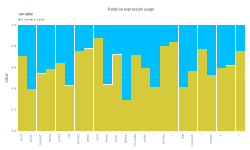

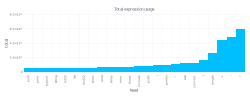

In [16]:
# let 
    df = make_count_df()
    df[:e_norm] = df[:e_count] / sum(df[:e_count])
    df[:b_norm] = df[:b_count] / sum(df[:b_count])
    df[:total] = df[:e_count] + df[:b_count]
    sort!(df, cols=:total)

    @byrow! df begin # Setting to sum = 1
        e = :e_norm
        b = :b_norm
        :e_norm = e/(e+b) 
        :b_norm = b/(e+b)
    end

    df_stacked = stack(df, [:b_norm, :e_norm], [:h,:head, :total]);
    df_stacked = df_stacked[df_stacked[:total].> 5000,:] # only large values
# df_stacked = df_stacked[abs(df_stacked[:value] - .5) .> .25, :] # Only get large variations
    
    a = plot(df_stacked,
        x="head",
        y="value",
        color="variable",
        Geom.bar(position=:stack),
        Theme(guide_title_position=:left,
            key_position=:top,
            bar_highlight=color("white")
        ),
        Guide.title("Relative expression usage"),
        Guide.xlabel(nothing),
        Guide.xticks(orientation=:vertical),
        Guide.annotation(compose(context(), rectangle(0, .4995, 100, .001), fill("white")))
    )

    b = plot(df_stacked, 
             x="head", 
             y="total",
             Geom.bar,
#              Scale.y_log10,
             Guide.title("Total expression usage"),
            Guide.xticks(orientation=:vertical)
        )

    draw(SVGJS(25cm, 15cm), a)
    draw(SVG(25cm, 10cm), b) 
# end

In [ ]:
df = make_count_df()

In [ ]:
let not_included = setdiff(c_bdf[:h], c_edf[:h])
    @byrow c_bdf begin
        if :h in 

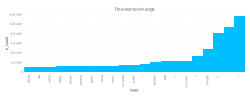

In [40]:
# df_b = deepcopy(df)
# sort(df, b_count)

a = plot(sort(df, cols=:e_count)[end-20:end,:], 
             x="head", 
y="e_count",
             Geom.bar,
#              Scale.y_log10,
             Guide.title("Total expression usage"),
            Guide.xticks(orientation=:vertical)
        )

b = plot(sort(df, cols=:b_count)[end-20:end,:], 
             x="head", 
y="b_count",
             Geom.bar,
#              Scale.y_log10,
             Guide.title("Total expression usage"),
            Guide.xticks(orientation=:vertical)
        )

    draw(SVGJS(25cm, 10cm), a)
    draw(SVG(25cm, 10cm), b) 